# Satellite image classification using ResNet50

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import ResNet50
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

In [3]:
# Global parameters
image_size = 256
train_folder = "Images/train/"
test_folder = "Images/test/"
train_batchsize = 64
val_batchsize = 16

In [4]:
def create_model_with_additional_layers(model_name, image_size):
    if model_name == "vgg16":
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "vgg19":
        pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "xception":
        pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "resnet50":
        pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionV3":
        pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionresnetV2":
        pretrained_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "mobilenet":
        pretrained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    else:
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    # Freeze all the layers
    for layer in pretrained_model.layers[:]:
        layer.trainable = False
    # Check the trainable status of the individual layers
    for layer in pretrained_model.layers:
        print(layer, layer.trainable)
    # Create the model
    model = models.Sequential()
    # Add the vgg convolutional base model
    model.add(pretrained_model)
    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(21, activation='softmax'))
    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    return model

In [5]:
def create_model_with_retrainable_layers(model_name, image_size):
    if model_name == "vgg16":
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "vgg19":
        pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "xception":
        pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "resnet50":
        pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionV3":
        pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    else:
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all the layers
    for layer in pretrained_model.layers[:-4]:
        layer.trainable = False

    # Check the trainable status of the individual layers
    for layer in pretrained_model.layers:
        print(layer, layer.trainable)

    # Create the model
    model = models.Sequential()
    # Add the vgg convolutional base model
    model.add(pretrained_model)
    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(21, activation='softmax'))
    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    return model

In [7]:
def train_model(model, train_folder, test_folder, train_batchsize, val_batchsize, image_size, filename,
                epochs = 3,classmode='categorical', lr=1e-4):
    # No Data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Data Generator for Training data
    train_generator = train_datagen.flow_from_directory(
            train_folder,
            target_size=(image_size, image_size),
            batch_size=train_batchsize,
            class_mode=classmode)

    # Data Generator for Validation data
    validation_generator = validation_datagen.flow_from_directory(
            test_folder,
            target_size=(image_size, image_size),
            batch_size=val_batchsize,
            class_mode=classmode,
            shuffle=False)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=lr),
                  metrics=['acc'])

    # Train the Model
    history = model.fit_generator(
      train_generator, train_generator.n // train_batchsize, epochs=epochs, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // val_batchsize)

    # Save the Model
    model.save(filename)
    return model, history

In [8]:
def plot_training_process(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [9]:
from random import randint

def show_result(model, test_folder, image_size, classmode='categorical'):
    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    # Create a generator for prediction
    validation_generator = validation_datagen.flow_from_directory(
        test_folder,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

    # Get the filenames from the generator
    fnames = validation_generator.filenames

    # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the label to class mapping from the generator
    label2index = validation_generator.class_indices

    # Getting the mapping from class index to class label
    idx2label = dict((v, k) for k, v in label2index.items())

    # Get the predictions from the model using the generator
    predictions = model.predict_generator(validation_generator,
                                          steps=validation_generator.samples / validation_generator.batch_size,
                                          verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("No of errors = {}/{}".format(len(errors), validation_generator.samples))

    # Show the errors
    for i in range(5):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(test_folder, fnames[errors[i]]))
        plt.figure(figsize=[7, 7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

# Experiment 1. Add 3 layers to pretrained ResNet50

In [12]:
model_resnet50 = create_model_with_additional_layers('resnet50', image_size=image_size)

<keras.engine.topology.InputLayer object at 0x7f807416d6a0> False
<keras.layers.convolutional.Conv2D object at 0x7f80d4a3a588> False
<keras.layers.normalization.BatchNormalization object at 0x7f807416d860> False
<keras.layers.core.Activation object at 0x7f807416db38> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8074096cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f80740abf60> False
<keras.layers.normalization.BatchNormalization object at 0x7f807405e240> False
<keras.layers.core.Activation object at 0x7f8063b42a58> False
<keras.layers.convolutional.Conv2D object at 0x7f8063b566d8> False
<keras.layers.normalization.BatchNormalization object at 0x7f8063b02550> False
<keras.layers.core.Activation object at 0x7f8063ac76a0> False
<keras.layers.convolutional.Conv2D object at 0x7f8063af87f0> False
<keras.layers.convolutional.Conv2D object at 0x7f8063a015f8> False
<keras.layers.normalization.BatchNormalization object at 0x7f8063aa24a8> False
<keras.layers.normalization.Ba

In [13]:
model_trained_resnet50, history_resnet50 = train_model(model=model_resnet50, train_folder=train_folder, test_folder=test_folder,
        train_batchsize=train_batchsize, val_batchsize=val_batchsize, image_size=image_size, filename="xception.h5",
                                         lr=3e-5, epochs=20)

Found 6803 images belonging to 21 classes.
Found 1600 images belonging to 21 classes.
Epoch 1/20
106/106 [==============================] - 63s 591ms/step - loss: 2.1468 - acc: 0.3819 - val_loss: 3.2760 - val_acc: 0.0475
Epoch 2/20
106/106 [==============================] - 61s 574ms/step - loss: 0.9116 - acc: 0.7673 - val_loss: 3.6553 - val_acc: 0.0075
Epoch 3/20
106/106 [==============================] - 61s 573ms/step - loss: 0.5154 - acc: 0.8727 - val_loss: 4.1998 - val_acc: 0.0187
Epoch 4/20
106/106 [==============================] - 61s 572ms/step - loss: 0.3467 - acc: 0.9111 - val_loss: 4.4958 - val_acc: 0.0338
Epoch 5/20
106/106 [==============================] - 61s 575ms/step - loss: 0.2469 - acc: 0.9372 - val_loss: 4.3024 - val_acc: 0.0694
Epoch 6/20
106/106 [==============================] - 61s 574ms/step - loss: 0.2035 - acc: 0.9465 - val_loss: 3.3414 - val_acc: 0.1519
Epoch 7/20
106/106 [==============================] - 61s 573ms/step - loss: 0.1611 - acc: 0.9562 - val_

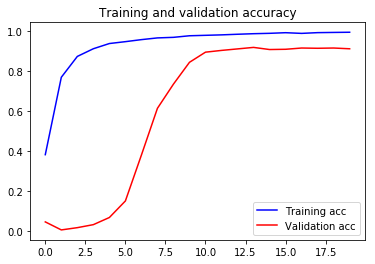

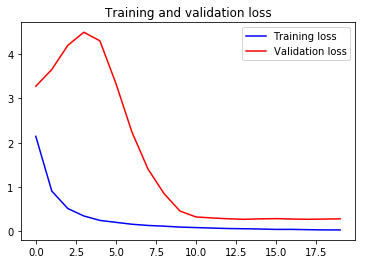

In [14]:
plot_training_process(history=history_resnet50)

Found 1600 images belonging to 21 classes.
100/100 [==============================] - 14s 142ms/step
No of errors = 143/1600


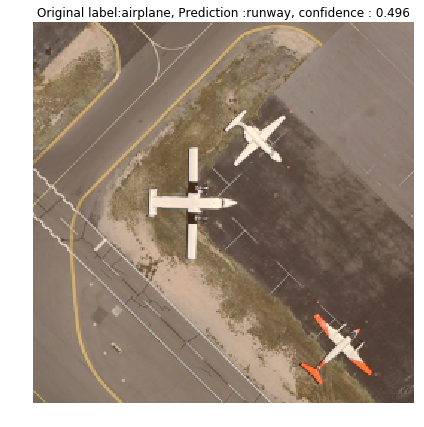

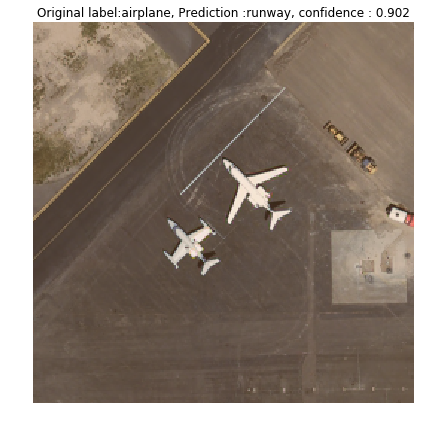

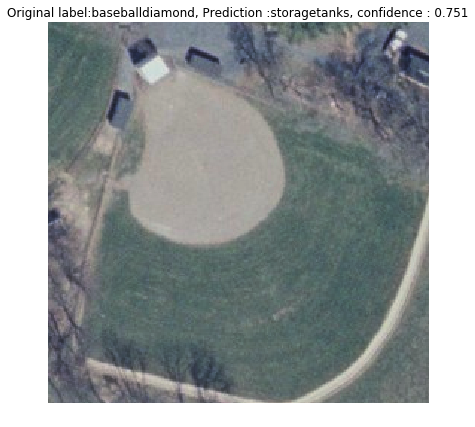

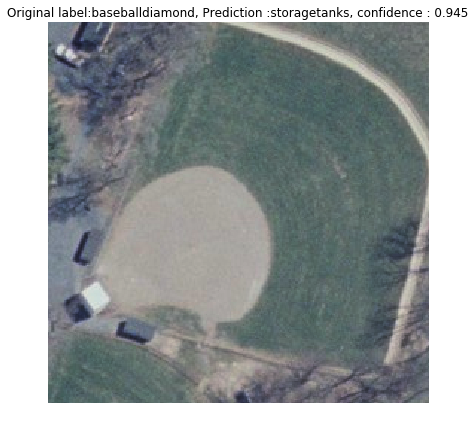

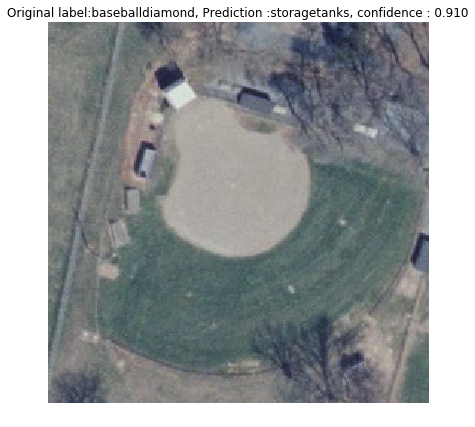

In [15]:
show_result(model_trained_resnet50, test_folder=test_folder, image_size=image_size)

# Experiment 2. Retrain 4 last layers

In [16]:
model_resnet50_retrainable_layers = create_model_with_retrainable_layers("resnet50", image_size=image_size)

<keras.engine.topology.InputLayer object at 0x7f7e948beda0> False
<keras.layers.convolutional.Conv2D object at 0x7f7e946ded68> False
<keras.layers.normalization.BatchNormalization object at 0x7f7e946a52e8> False
<keras.layers.core.Activation object at 0x7f7e946e41d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7e946aac18> False
<keras.layers.convolutional.Conv2D object at 0x7f7e946baf60> False
<keras.layers.normalization.BatchNormalization object at 0x7f7e9462dac8> False
<keras.layers.core.Activation object at 0x7f7e945dc128> False
<keras.layers.convolutional.Conv2D object at 0x7f7e945dc860> False
<keras.layers.normalization.BatchNormalization object at 0x7f7e94583940> False
<keras.layers.core.Activation object at 0x7f7e94560550> False
<keras.layers.convolutional.Conv2D object at 0x7f7e9450d7b8> False
<keras.layers.convolutional.Conv2D object at 0x7f7e944fd780> False
<keras.layers.normalization.BatchNormalization object at 0x7f7e94538b38> False
<keras.layers.normalization.Ba

In [17]:
model_trained_resnet50_retrainable_layers, history_resnet50_retrainable_layers = train_model(epochs=20, lr=1e-4, model=model_resnet50_retrainable_layers, train_folder=train_folder,
             test_folder=test_folder, train_batchsize=train_batchsize, val_batchsize=val_batchsize, image_size=image_size,
                                                      filename="resnet50_lats4.h5")

Found 6803 images belonging to 21 classes.
Found 1600 images belonging to 21 classes.
Epoch 1/20
106/106 [==============================] - 62s 588ms/step - loss: 1.0568 - acc: 0.6976 - val_loss: 4.6573 - val_acc: 0.0475
Epoch 2/20
106/106 [==============================] - 61s 577ms/step - loss: 0.2684 - acc: 0.9244 - val_loss: 6.8181 - val_acc: 0.0475
Epoch 3/20
106/106 [==============================] - 61s 576ms/step - loss: 0.1407 - acc: 0.9609 - val_loss: 6.9510 - val_acc: 0.0475
Epoch 4/20
106/106 [==============================] - 61s 576ms/step - loss: 0.0894 - acc: 0.9773 - val_loss: 7.5449 - val_acc: 0.0525
Epoch 5/20
106/106 [==============================] - 61s 576ms/step - loss: 0.0677 - acc: 0.9813 - val_loss: 6.5287 - val_acc: 0.0788
Epoch 6/20
106/106 [==============================] - 61s 576ms/step - loss: 0.0497 - acc: 0.9858 - val_loss: 4.5836 - val_acc: 0.1675
Epoch 7/20
106/106 [==============================] - 61s 577ms/step - loss: 0.0395 - acc: 0.9893 - val_

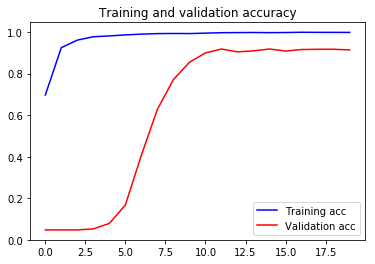

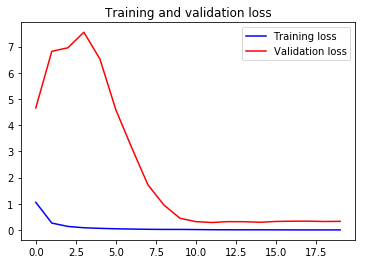

In [18]:
plot_training_process(history_resnet50_retrainable_layers)

Found 1600 images belonging to 21 classes.
100/100 [==============================] - 14s 143ms/step
No of errors = 138/1600


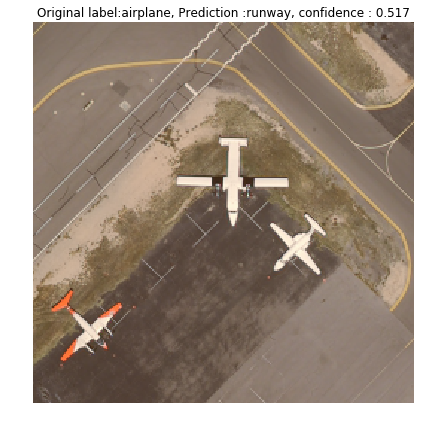

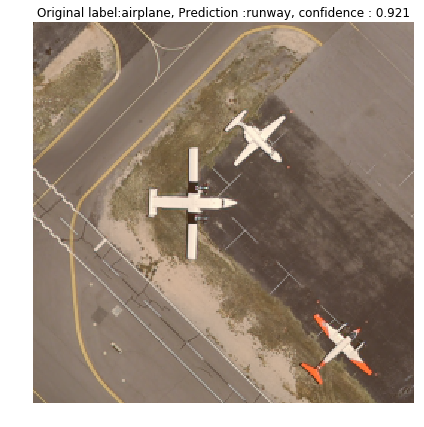

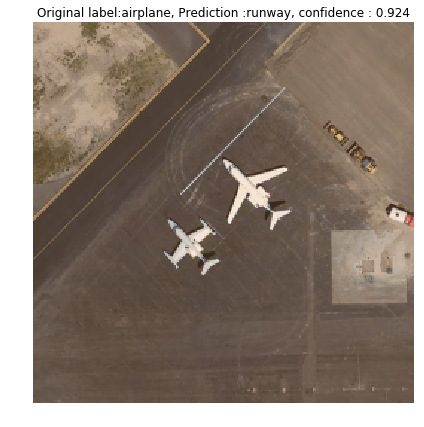

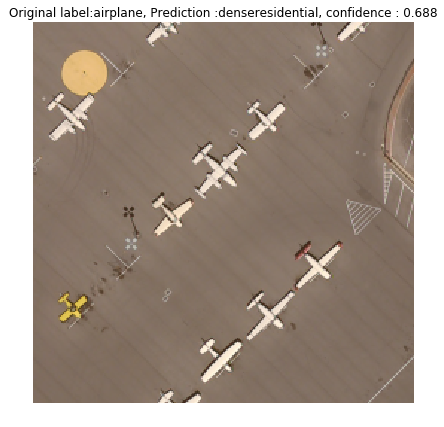

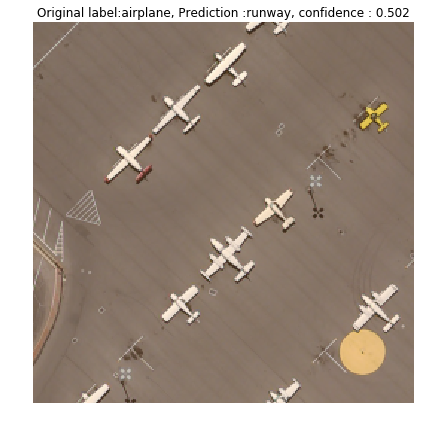

In [19]:
show_result(model=model_trained_resnet50_retrainable_layers, image_size=image_size, test_folder=test_folder)